## Downloading the dataset

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 12.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=c5f4bc189d0211566b9f8a5f8a0d8afcfdb7f8dba76e4a6cce08f13062b90915
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pyspark
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
import re
import json
import itertools
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from operator import add
import numpy as np
import nltk 
from textblob import TextBlob
from textblob import Word
from nltk.corpus import stopwords
from itertools import groupby
from operator import itemgetter
from sklearn import metrics 

In [ ]:
## Helper Functions
def extract_year_Movie(string):
    match = re.search(r'\((\d{4})\)', string)
    if match:
        return match.group(1)
    else:
        return None


def extract_text_Movie(string):
    match = re.search(r'(.*)\s\(\d{4}\)', string)
    if match:
        return match.group(1)
    else:
        return None

def extract_years_Tv(string):
    match = re.search(r'\((\d{4})–\s?(\d{4})?\)', string)
    if match:
        start_year = match.group(1)
        end_year = match.group(2)
        if end_year:
            return "({}-{})".format(start_year, end_year)
        else:
            return "({}-)".format(start_year)
    else:
        return None

def extract_text_Tv(string):
    match = re.search(r'(.*)\s\(\d{4}–\s?(\d{4})?\)', string)
    if match:
        return match.group(1)
    else:
        return None
        

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! kaggle datasets download ebiswas/imdb-review-dataset

100% 2.68G/2.69G [00:34<00:00, 112MB/s] 
100% 2.69G/2.69G [00:34<00:00, 83.3MB/s]


In [ ]:
!unzip imdb-review-dataset.zip

Archive:  imdb-review-dataset.zip
  inflating: part-01.json            
  inflating: part-02.json            
  inflating: part-03.json            
  inflating: part-04.json            
  inflating: part-05.json            
  inflating: part-06.json            
  inflating: sample.json             


## Reading the data by Spark

In [ ]:
!pip3 install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
sc = pyspark.SparkContext(appName="Final_Project")
spark = SparkSession(sc)

## Contiune Spark RDD

In [ ]:
path = '/content/drive/MyDrive/BigData_FinalProject/Splits1/*.json'
data_rdd = spark.read.option("multiline","true").json(path).rdd

In [ ]:
num_reviews = data_rdd.count()

Requirments we want to do
1. Lowest Rated Shows
2. Highest Rated Shows
3. Number of Spoiled Reviews
4. Shows with the highest number of helpful reviews 
5. Shows  with the highest number of reviews
6. Shows with the highest number of ratings 
7. The highest rated Show in each year
8. The year which has the highest movies releases

# Lowest ratings  movies

In [ ]:
Temp = data_rdd.filter(lambda x:x['rating']!= None)
Mov = Temp.map(lambda x:((x['movie']),1)).filter(lambda x:x[0] != None).reduceByKey(lambda a, b: a + b).sortBy(lambda x: x[1], ascending = False)

In [ ]:
#Creating a dictionary, its key would be the Movie name and the value number of rating it has
Movies_Names = {}
Mov_Collect = Mov.collect()
for i in range(len(Mov_Collect)):
  Movies_Names[Mov_Collect[i][0]] = Mov_Collect[i][1]

In [ ]:
Movies_Ratings = Temp.map(lambda x:(x['movie'],x['rating'])).map(lambda x:(x[0],int(x[1])))
Movies_Average_Rating = Movies_Ratings.reduceByKey(add).map(lambda x:(extract_text_Movie(x[0]),float(round(x[1]/Movies_Names[x[0]],2)))).filter(lambda x:x[0]!= None).filter(lambda x:x[1] > 3)

In [ ]:
Movies_Average_Rating.take(10)

[('Prometheus', 9.5),
 ('Rossini', 7.33),
 ('Gettysburg', 7.35),
 ('True Legend', 8.17),
 ('Zhifu', 7.5),
 ('District 9', 7.75),
 ("Mackenna's Gold", 6.06),
 ('Der Lauf der Dinge', 5.5),
 ('Liberty Heights', 7.0),
 ("Winchester '73", 7.32)]

In [ ]:
Lowest_Average_Rating = Movies_Average_Rating.sortBy(lambda x: (x[1]), ascending = True)

In [ ]:
Lowest_Average_Rating.take(10)

[('Edge of Fear', 3.01),
 ('Taxi 5', 3.03),
 ('The Houses October Built 2', 3.03),
 ('Whipped', 3.03),
 ('Catherine the Great', 3.03),
 ('Because I Said So', 3.03),
 ('War Pigs', 3.03),
 ('Knock Knock (I)', 3.04),
 ('Paydirt', 3.04),
 ('Supergirl: Back from the Future - Part One', 3.05)]

In [ ]:
a = Lowest_Average_Rating.collect()

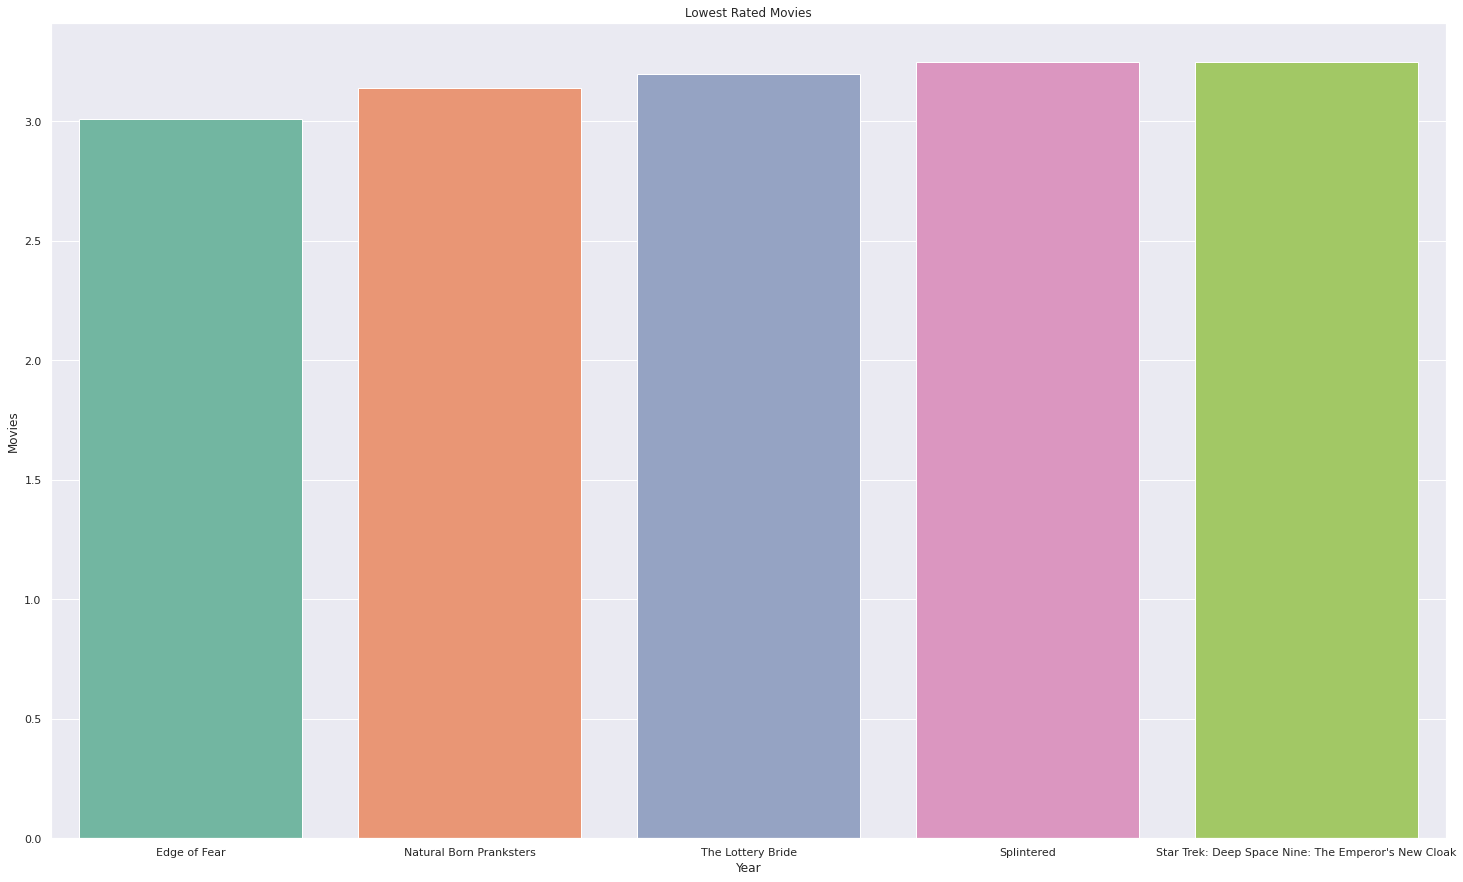

In [ ]:
sns.set(rc = {'figure.figsize':(25,15)})
plt.title("Lowest Rated Movies")
sns.barplot(x=[a[i][0] for i in range(0,500,100)],y=[a[i][1] for i in range(0,500,100)], palette='Set2')
plt.xlabel("Year")
plt.ylabel("Movies")
plt.show()

# Highest ratings  movies

In [ ]:
Highest_Average_Rating = Movies_Average_Rating.sortBy(lambda x: float(x[1]), ascending = False).filter (lambda x:x[1] <9.5)

In [ ]:
Highest_Average_Rating.take(10)

[('Surge (II)', 9.49),
 ("Supergirl: It's a Super Life", 9.49),
 ('Adventure Boyz', 9.49),
 ('Dark: Between the Time', 9.49),
 ('Return to the Hiding Place', 9.48),
 ('The Walking Dead: Too Far Gone', 9.48),
 ('Tijuana Jackson: Purpose Over Prison', 9.48),
 ('The 100: Damocles: Part Two', 9.48),
 ('異形', 9.48),
 ('Moondru Per Moondru Kaadhal', 9.48)]

In [ ]:
a = Highest_Average_Rating.collect()

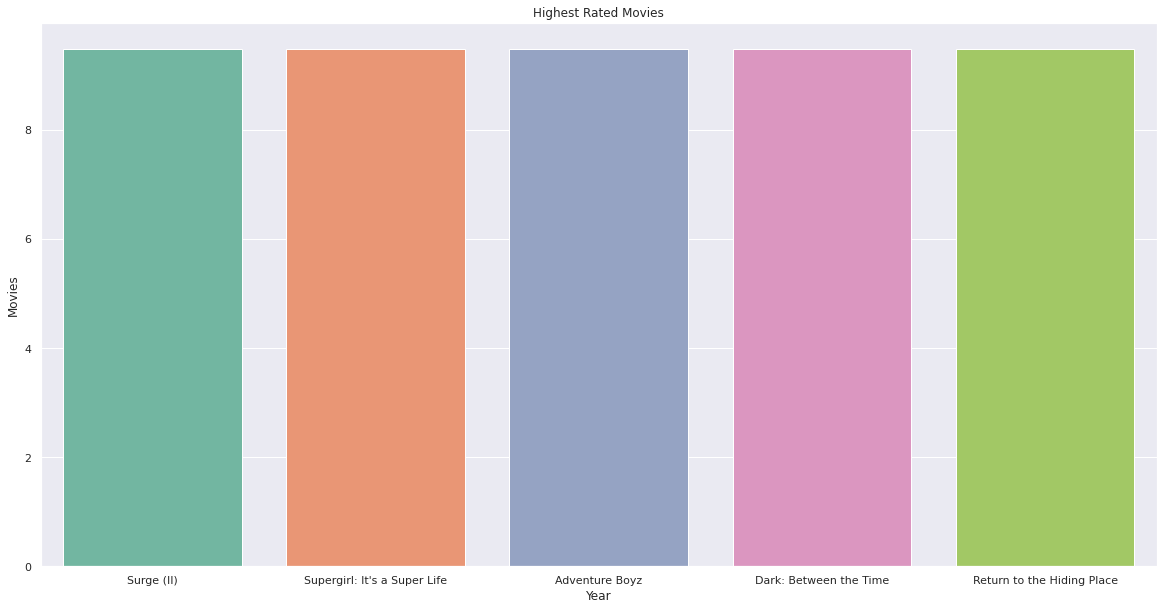

In [ ]:
sns.set(rc = {'figure.figsize':(20,10)})
plt.title("Highest Rated Movies")
sns.barplot(x=[a[i][0] for i in range(0,5)],y=[a[i][1] for i in range(0,5)], palette='Set2')
plt.xlabel("Year")
plt.ylabel("Movies")
plt.show();

# Lowest ratings  TV Shows

In [ ]:
TV_Average_Rating = Movies_Ratings.map(lambda x:(extract_text_Tv(x[0]),round(x[1]/Movies_Names[x[0]],2))).filter(lambda x:x[0]!= None).filter(lambda x:x[1] > 3)

In [ ]:
TV_Average_Rating.take(10)

[('The Vice Guide to Travel', 9.0),
 ('Patrolling with Sean Kennedy', 9.0),
 ('Tweenies', 3.5),
 ('Massuguna otoko', 7.0),
 ('Hot Hero Sandwich', 10.0),
 ('Fantastic Four: The Animated Series', 3.5),
 ('¿Qué apostamos?', 10.0),
 ('Royal Recipes', 10.0),
 ('The Incredible Hulk', 9.0),
 ('Marvin the Tap-Dancing Horse', 10.0)]

In [ ]:
Lowest_Average_Rating = TV_Average_Rating.sortBy(lambda x: float(x[1]), ascending = True)

In [ ]:
Lowest_Average_Rating.take(10)

[('HIStory', 3.33),
 ('Life on Earth', 3.33),
 ('Eat. Race. Win.', 3.33),
 ('Rebelde Way', 3.33),
 ('Corazón salvaje', 3.33),
 ('The Friendly Giant', 3.33),
 ("On Tour with Asperger's Are Us", 3.33),
 ('Skam NL', 3.33),
 ('Single by 30', 3.33),
 ('José do Egito', 3.33)]

In [ ]:
a = Lowest_Average_Rating.collect()

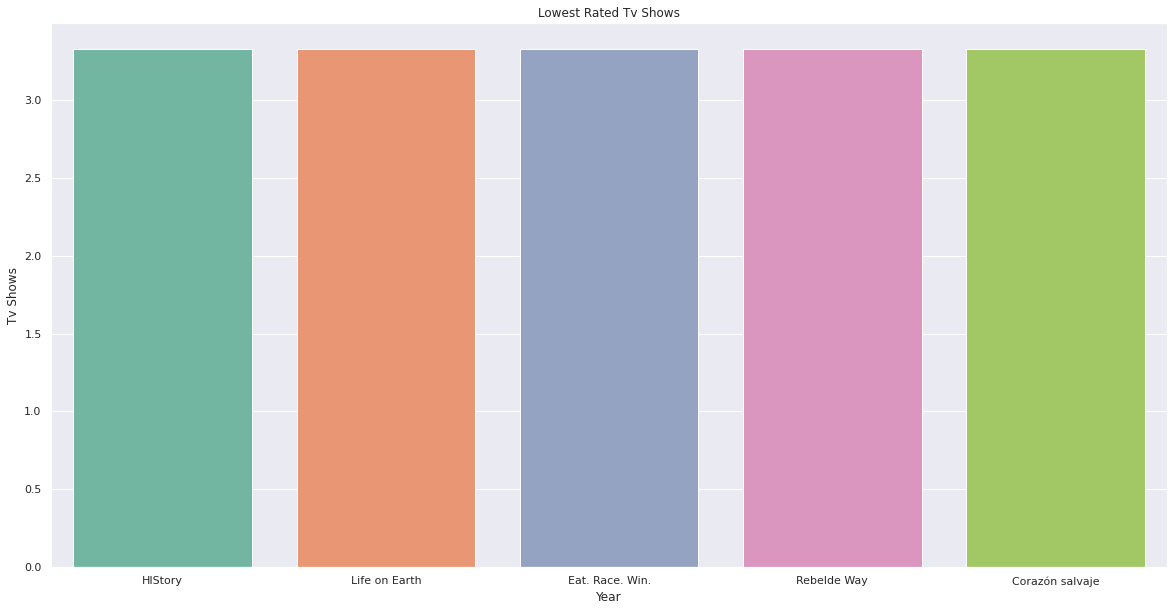

In [ ]:
sns.set(rc = {'figure.figsize':(20,10)})
plt.title("Lowest Rated Tv Shows")
sns.barplot(x=[a[i][0] for i in range(0,5)],y=[a[i][1] for i in range(0,5)], palette='Set2')
plt.xlabel("Year")
plt.ylabel("Tv Shows")
plt.show()

# Highest ratings  TV Shows

In [ ]:
Highest_Average_Rating = TV_Average_Rating.sortBy(lambda x: float(x[1]), ascending = False).filter (lambda x:x[1] <9.5)

In [ ]:
Highest_Average_Rating.take(10)

[('The Vice Guide to Travel', 9.0),
 ('Patrolling with Sean Kennedy', 9.0),
 ('The Incredible Hulk', 9.0),
 ('Taeyangeul ssamkyeora', 9.0),
 ('Dastardly and Muttley in Their Flying Machines', 9.0),
 ('Wild Things', 9.0),
 ('Shôkôjo Seira', 9.0),
 ('Ishi no mayu', 9.0),
 ('Syn', 9.0),
 ('Murdoch Mysteries: The Curse of the Lost Pharaohs', 9.0)]

In [ ]:
a = Highest_Average_Rating.collect()

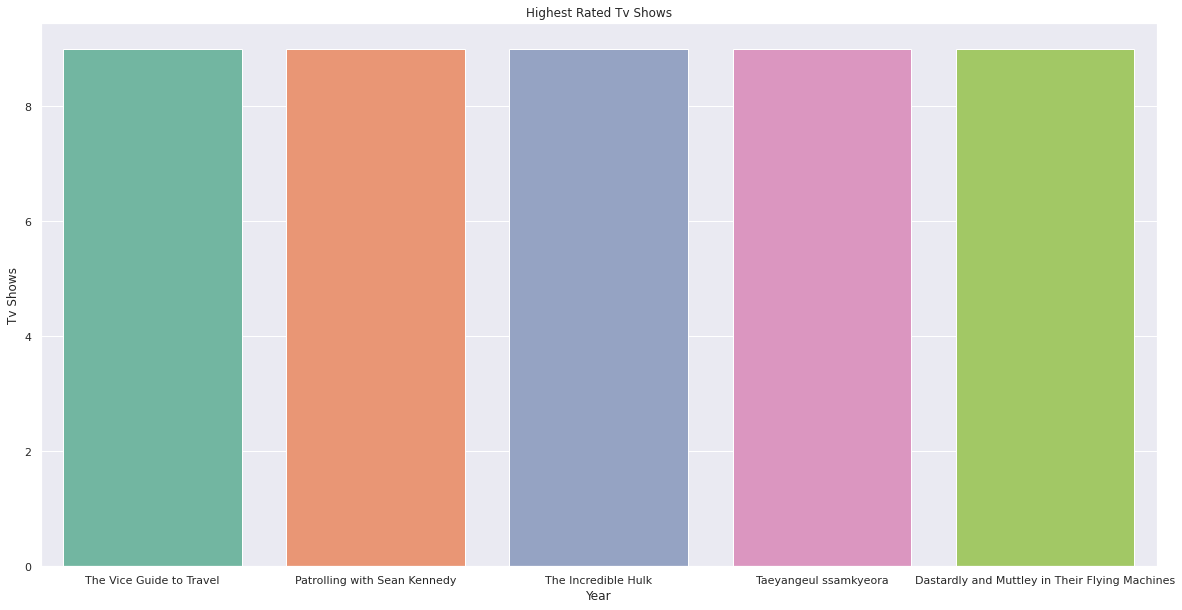

In [ ]:
sns.set(rc = {'figure.figsize':(20,10)})
plt.title("Highest Rated Tv Shows")
sns.barplot(x=[a[i][0] for i in range(0,5)],y=[a[i][1] for i in range(0,5)], palette='Set2')
plt.xlabel("Year")
plt.ylabel("Tv Shows")
plt.show()

# Number of Spoiled Reviews

In [ ]:
Reviews_Numbers = data_rdd.map(lambda x:((x['spoiler_tag']),1)).reduceByKey(lambda a, b: a + b)

In [ ]:
a = Reviews_Numbers.collect()

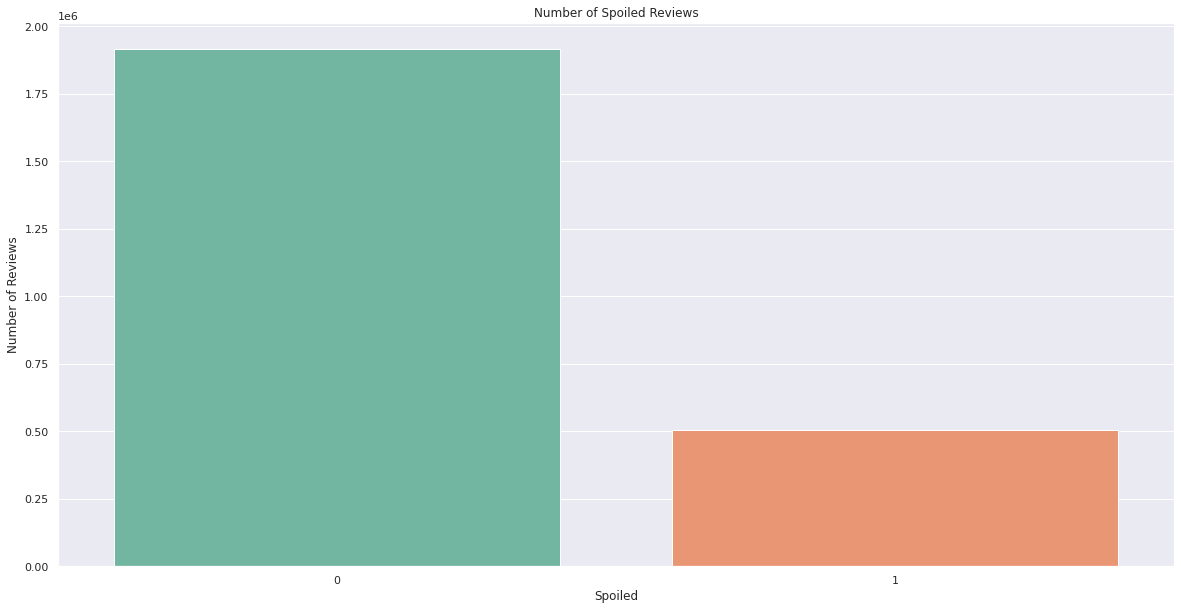

In [ ]:
sns.set(rc = {'figure.figsize':(20,10)})
plt.title("Number of Spoiled Reviews")
sns.barplot(x=[a[i][0] for i in range(0,2)],y=[a[i][1] for i in range(0,2)], palette='Set2')
plt.xlabel("Spoiled")
plt.ylabel("Number of Reviews")
plt.show()

# Shows With The Highest Number of Helpful Reviews ?

In [ ]:
Helpful_Reviews = data_rdd.map(lambda x:((x['movie'],(x['helpful'][0])))).map(lambda x:(x[0],int((''.join(x[1].split(',')))))).reduceByKey(lambda a, b: a + b)
Movies_Helpful_Reviews = Helpful_Reviews.map(lambda x: (extract_text_Movie(x[0]),x[1])).filter(lambda x:x[0] != None)
Tv_Helpful_Reviws = Helpful_Reviews.map(lambda x: (extract_text_Tv (x[0]),x[1])).filter(lambda x:x[0] != None).sortBy(lambda x: float(x[1]), ascending = False)

In [ ]:
Movies_Helpful_Reviews.take(5)

[('Prometheus', 17),
 ('Rossini', 14),
 ('Gettysburg', 142),
 ('True Legend', 107),
 ('Zhifu', 13)]

In [ ]:
Tv_Helpful_Reviws.take(5)

[('Star Trek: Discovery', 77072),
 ('獵魔士', 55867),
 ('Game of Thrones', 51972),
 ('Star Trek: Picard', 47830),
 ('Chilling Adventures of Sabrina', 36974)]

In [ ]:
a = Tv_Helpful_Reviws.collect()

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29557 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 39764 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22763 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 29557 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 39764 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 22763 missing from current font.
  font.set_text

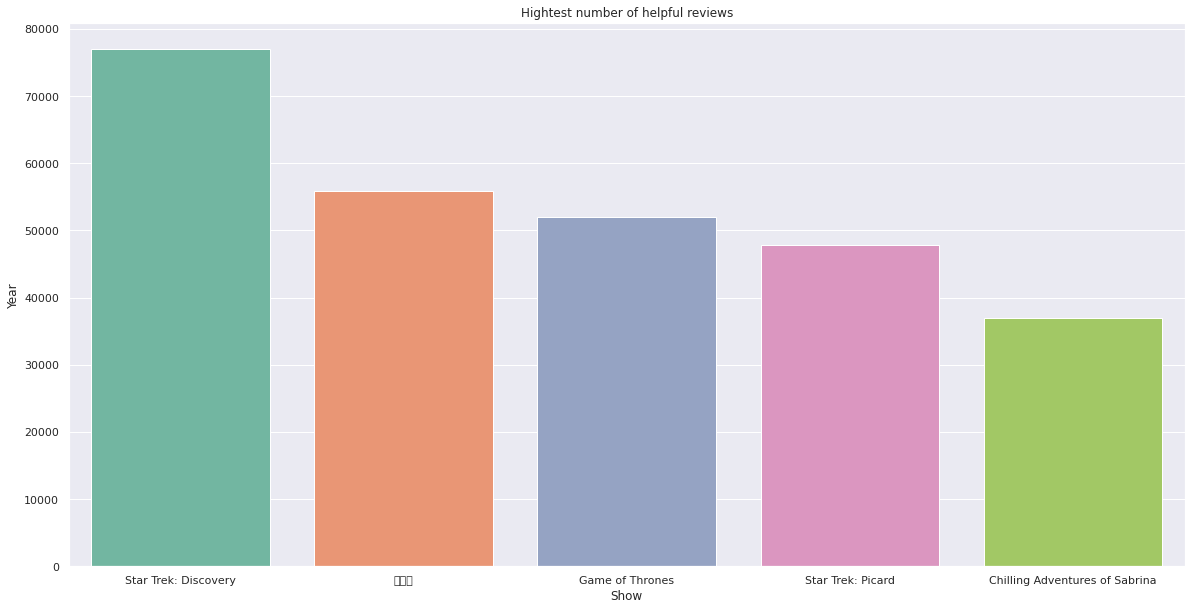

In [ ]:
sns.set(rc = {'figure.figsize':(20,10)})
plt.title("Hightest number of helpful reviews")
sns.barplot(x=[a[i][0] for i in range(0,5)],y=[a[i][1] for i in range(0,5)], palette='Set2')
plt.xlabel("Show")
plt.ylabel("Year")
plt.show()

In [ ]:
a = Movies_Helpful_Reviews.collect()

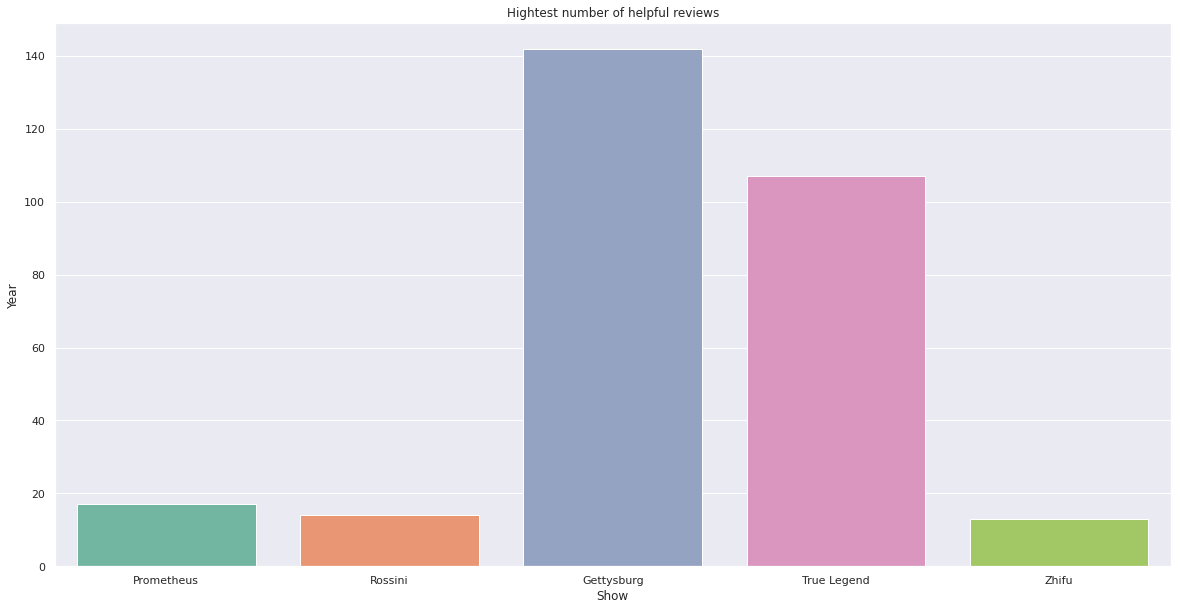

In [ ]:
sns.set(rc = {'figure.figsize':(20,10)})
plt.title("Hightest number of helpful reviews")
sns.barplot(x=[a[i][0] for i in range(0,5)],y=[a[i][1] for i in range(0,5)], palette='Set2')
plt.xlabel("Show")
plt.ylabel("Year")
plt.show()

# Movies and Tv Shows with the highest number of reviews

In [ ]:
Movies_Reviews = Mov.map(lambda x:(extract_text_Movie(x[0]),x[1])).filter(lambda x:x[0] != None)

In [ ]:
Movies_Reviews.take(5)

[('Avengers: Endgame', 7788),
 ('Dil Bechara', 7735),
 ('Wonder Woman 1984', 6724),
 ('小丑', 6450),
 ('Mrs. Serial Killer', 5377)]

In [ ]:
a = Movies_Reviews.collect()

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23567 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 19985 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 23567 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 19985 missing from current font.
  font.set_text(s, 0, flags=flags)


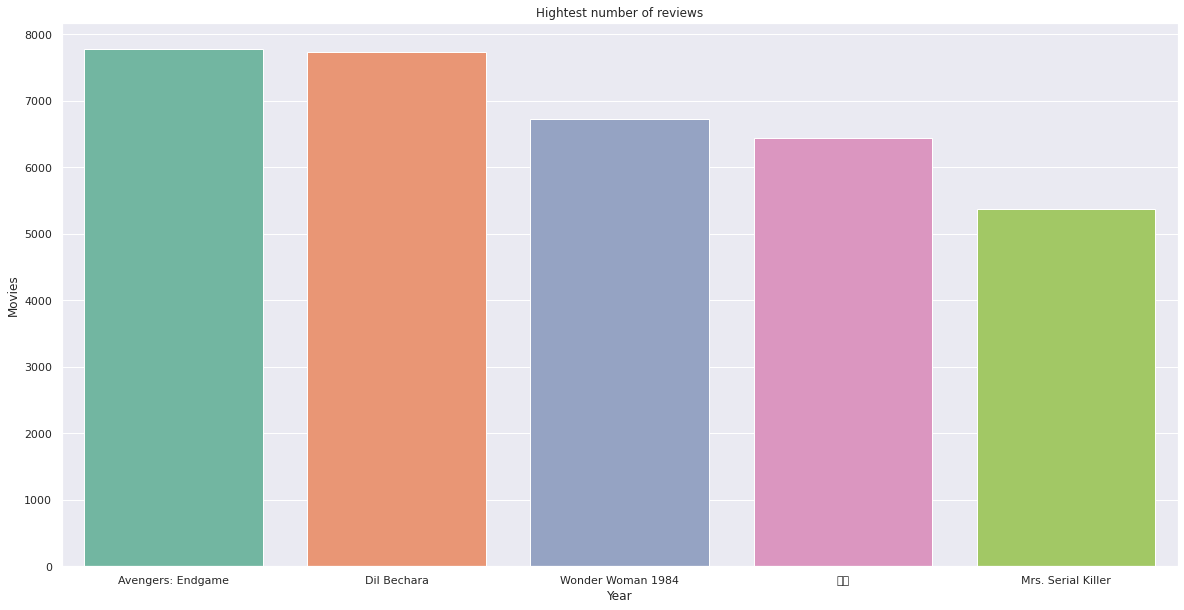

In [ ]:
sns.set(rc = {'figure.figsize':(20,10)})
plt.title("Hightest number of reviews")
sns.barplot(x=[a[i][0] for i in range(0,5)],y=[a[i][1] for i in range(0,5)], palette='Set2')
plt.xlabel("Year")
plt.ylabel("Movies")
plt.show()

In [ ]:
Tv_Reviews = Mov.map(lambda x:(extract_text_Tv(x[0]),x[1])).filter(lambda x:x[0] != None)

In [ ]:
Tv_Reviews.take(5)    

[('Asur: Welcome to Your Dark Side', 3189),
 ('The Chosen', 2993),
 ('Dark', 2796),
 ('獵魔士', 2703),
 ('Game of Thrones', 2553)]

In [ ]:
a = Tv_Reviews.collect()

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29557 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 39764 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22763 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 29557 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 39764 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 22763 missing from current font.
  font.set_text

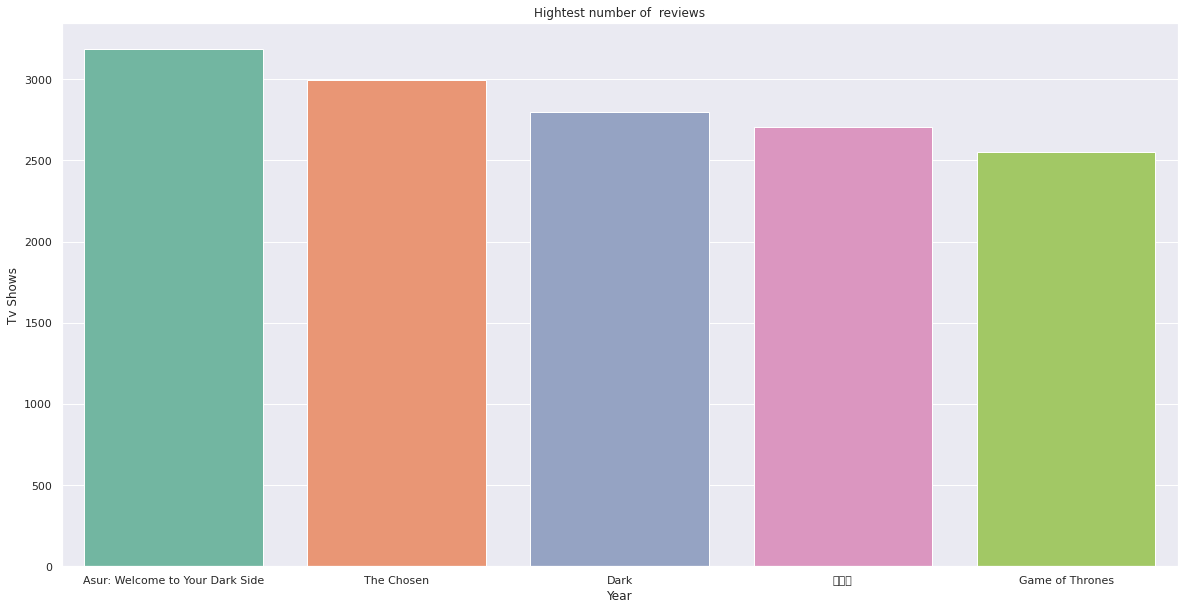

In [ ]:
sns.set(rc = {'figure.figsize':(20,10)})
plt.title("Hightest number of  reviews")
sns.barplot(x=[a[i][0] for i in range(0,5)],y=[a[i][1] for i in range(0,5)], palette='Set2')
plt.xlabel("Year")
plt.ylabel("Tv Shows")
plt.show()

# The Highest Rated Show in each year

In [ ]:
Movies_Years_Ratings = Temp.map(lambda x:((x['movie']),float(x['rating']))).reduceByKey(add)
Movies_Years_Ratings = Movies_Years_Ratings.map(lambda x:(extract_year_Movie(x[0]),extract_text_Movie(x[0]),round(x[1]/Movies_Names[x[0]],2))).filter(lambda x:x[0]!= None).filter (lambda x: 3< x[2] <9.5).collect()

In [ ]:
# Group the tuples by the  (year)
sorted_list = sorted(Movies_Years_Ratings, key=itemgetter(0),reverse=True)
year_groups = groupby(sorted_list, key=itemgetter(0))
Each_Year_Name_Max = {}
# Get the  (name) of the tuple with the maximum rating in each year
for year, group in year_groups:
    max_tuple = max(group, key=lambda x: x[2])
    max_name = max_tuple[1]
    Each_Year_Name_Max[int(year)] = (max_tuple[1],max_tuple[2])
print("Maximum names list:", Each_Year_Name_Max)

Maximum names list: {2021: ('Cobra Kai: King Cobra', 9.33), 2020: ('Surge (II)', 9.49), 2019: ('Adventure Boyz', 9.49), 2018: ('Tijuana Jackson: Purpose Over Prison', 9.48), 2017: ('Rockaway', 9.45), 2016: ('Person of Interest: The Day the World Went Away', 9.44), 2015: ('MSG 2 the Messenger', 9.47), 2014: ('We Are Twisted Fucking Sister!', 9.48), 2013: ('Return to the Hiding Place', 9.48), 2012: ('Strawinsky and the Mysterious House', 9.47), 2011: ('TT3D: Closer to the Edge', 9.45), 2010: ('The Walking Dead: Days Gone Bye', 9.45), 2009: ('Monpura', 9.42), 2008: ('The Office: Goodbye, Toby', 9.44), 2007: ('Doctor Who: Blink', 9.44), 2006: ('Last Stop for Paul', 9.45), 2005: ('Doctor Who: Dalek', 9.44), 2004: ('Lost: Pilot: Part 2', 9.4), 2003: ('Interstella 5555: The 5tory of the 5ecret 5tar 5ystem', 9.45), 2002: ('Tipping the Velvet', 9.44), 2001: ('The Sopranos: Employee of the Month', 9.4), 2000: ('Beyond the Pale', 9.4), 1999: ('綠色奇蹟', 9.33), 1998: ("Friends: The One with Ross's We

In [ ]:
years = []
for count,i in enumerate(Each_Year_Name_Max.keys()):
  if count == 5:
    break
  years.append(i)


In [ ]:
shows = []
for count,i in enumerate(Each_Year_Name_Max.values()):
  if count == 5:
    break
  print(i)
  shows.append(i)

('Cobra Kai: King Cobra', 9.33)
('Surge (II)', 9.49)
('Adventure Boyz', 9.49)
('Tijuana Jackson: Purpose Over Prison', 9.48)
('Rockaway', 9.45)


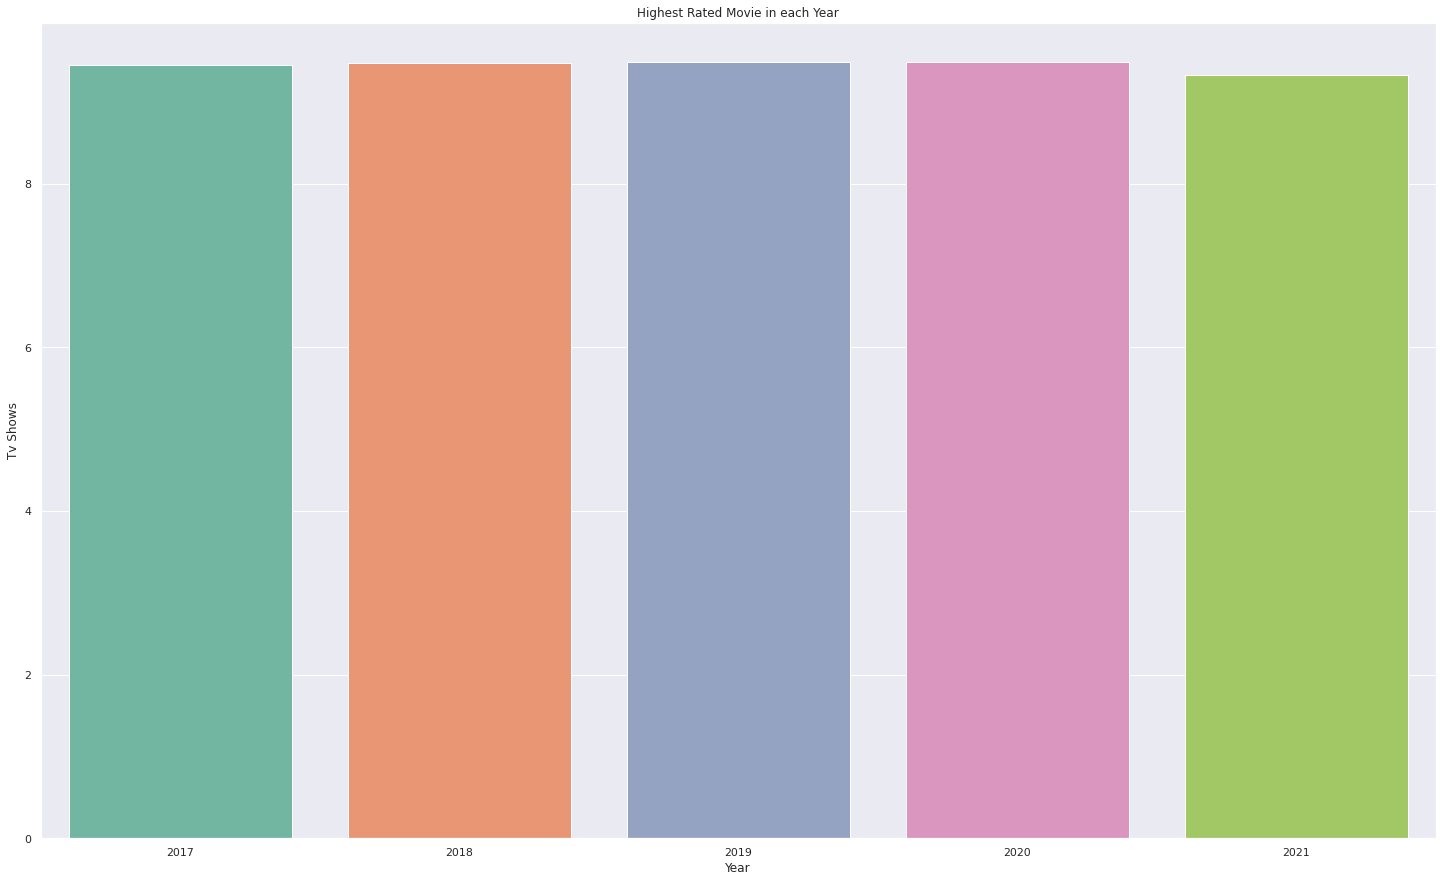

In [ ]:
### Not working
sns.set(rc = {'figure.figsize':(25,15)})
plt.title("Highest Rated Movie in each Year")
sns.barplot(x=[i for i in years  ],y=[i[1] for i in shows], palette='Set2')
plt.xlabel("Year")
plt.ylabel("Tv Shows")
plt.show()

# Years and number of movies and tv shows released

In [ ]:
Movies_Each_Year = Temp.map(lambda x:(extract_year_Movie(x['movie']),1)).filter(lambda x:x[0] != None).reduceByKey(lambda a, b: a + b)

In [ ]:
Movies_Each_Year.take(10)

[('1993', 8824),
 ('1979', 6085),
 ('1977', 5469),
 ('1980', 7132),
 ('2011', 48874),
 ('1997', 26767),
 ('1974', 5722),
 ('1922', 457),
 ('1944', 2677),
 ('1973', 6089)]

In [ ]:
a = Movies_Each_Year.collect()

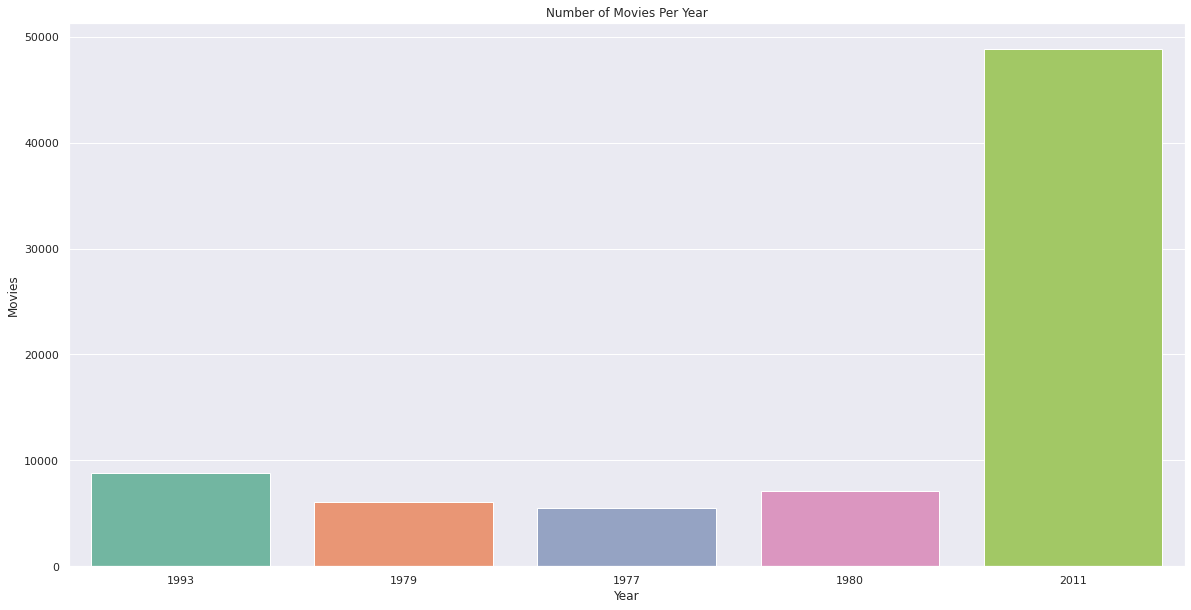

In [ ]:
sns.set(rc = {'figure.figsize':(20,10)})
plt.title("Number of Movies Per Year")
sns.barplot(x=[a[i][0] for i in range(0,5)],y=[a[i][1] for i in range(0,5)], palette='Set2')
plt.xlabel("Year")
plt.ylabel("Movies")
plt.show()

In [ ]:
Tv_Each_Year = Temp.map(lambda x:(extract_years_Tv(x['movie']),1)).filter(lambda x:x[0] != None).map(lambda x:(x[0].strip(')(').split('-')[0],x[1])).reduceByKey(lambda a, b: a + b)

In [ ]:
Tv_Each_Year.take(10)

[('1993', 860),
 ('1979', 273),
 ('2011', 11130),
 ('1980', 193),
 ('1977', 236),
 ('1997', 1435),
 ('1973', 220),
 ('1974', 257),
 ('2021', 533),
 ('2017', 29396)]

In [ ]:
a = Tv_Each_Year.collect()

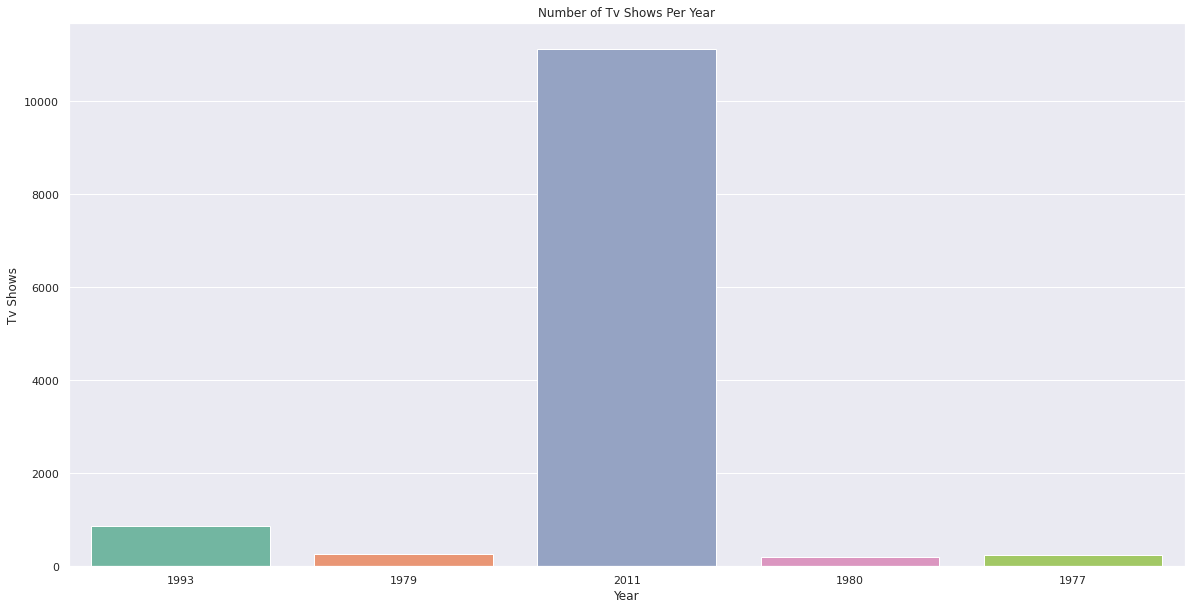

In [ ]:
sns.set(rc = {'figure.figsize':(20,10)})
plt.title("Number of Tv Shows Per Year")
sns.barplot(x=[a[i][0] for i in range(0,5)],y=[a[i][1] for i in range(0,5)], palette='Set2')
plt.xlabel("Year")
plt.ylabel("Tv Shows")
plt.show()